In this notebook we're trying to model the netflix movie rating data. This model can be the base for building a recommendation system. We're using neural network style collaborative filtering algorithm for this.

Link for data: https://www.kaggle.com/laowingkin/netflix-movie-recommendation/data

# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms


from torch.autograd import Variable

from fastai.conv_learner import *
from fastai.dataset import *

In [2]:
from copy import deepcopy

In [3]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [5]:
df = pd.read_csv(
    'data/net_data/combined_data_1.txt',
    header=None,
    names=['Cust_Id', 'Rating', 'Date'],
    usecols=[0, 1, 2])

In [6]:
df1 = pd.read_csv(
    'data/net_data/combined_data_2.txt',
    header=None,
    names=['Cust_Id', 'Rating', 'Date'],
    usecols=[0, 1, 2])

In [7]:
df = df.append(df1)

In [8]:
df1 = pd.read_csv(
    'data/net_data/combined_data_3.txt',
    header=None,
    names=['Cust_Id', 'Rating', 'Date'],
    usecols=[0, 1, 2])

In [9]:
df = df.append(df1)

In [10]:
df1 = pd.read_csv(
    'data/net_data/combined_data_4.txt',
    header=None,
    names=['Cust_Id', 'Rating', 'Date'],
    usecols=[0, 1, 2])

In [11]:
df = df.append(df1)
df.index = np.arange(0,len(df))

In [12]:
movie_meta = pd.read_csv(
    'data/movie_titles.csv',
    encoding="ISO-8859-1",
    header=None,
    names=['movie_id', 'year', 'name'])

In [13]:
movie_meta.head()

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [14]:
df.shape

(100498277, 3)

In [15]:
del(df1)

In [16]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100498277 entries, 0 to 100498276
Data columns (total 3 columns):
Cust_Id    object
Rating     float64
Date       object
dtypes: float64(1), object(2)
memory usage: 3.0+ GB


In [20]:
df.to_feather('data/net_data/df1')

# Data cleaning

Extracting movie IDs from the data

In [24]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))

df_nan = df_nan[df_nan['Rating'] == True]

df_nan = df_nan.reset_index()

In [25]:
del(df)

In [26]:
df_nan.dtypes

index     int64
Rating     bool
dtype: object

In [27]:
df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [30]:
movie_np = []
movie_id = 1

In [28]:
l = list(zip(df_nan['index'][1:], df_nan['index'][:-1]))

In [49]:
len(l)

17769

In [50]:
l[0]

(548, 0)

In [52]:
df = pd.read_feather('data/net_data/df1')

In [53]:
df.shape

(100498277, 3)

In [54]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100498277 entries, 0 to 100498276
Data columns (total 3 columns):
Cust_Id    object
Rating     float64
Date       object
dtypes: float64(1), object(2)
memory usage: 2.2+ GB


In [55]:
df.head()

,Cust_Id,Rating,Date
0,1:,NaN,None
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [56]:
df = df[pd.notnull(df['Rating'])]

In [59]:
temp = [e[0] - e[1] - 1 for e in l]

In [70]:
temp.append(df.shape[0] - np.sum(temp))

In [74]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 100498276
Data columns (total 3 columns):
Cust_Id    object
Rating     float64
Date       object
dtypes: float64(1), object(2)
memory usage: 3.0+ GB


In [75]:
df.isnull().sum()

Cust_Id    0
Rating     0
Date       0
dtype: int64

In [76]:
df.columns = ['cust_id', 'rating', 'date']

In [77]:
df['movie_id'] = None

In [138]:
movie_id = np.zeros(len(df))

In [139]:
movie_id.shape

(100480507,)

In [140]:
start = 0
for i, e in enumerate(temp):
    movie_id[start:start + e] = i + 1
    start = start + e

In [142]:
df['movie_id'] = movie_id

In [143]:
df.head()

,cust_id,rating,date,movie_id
1,1488844,3.0,2005-09-06,1.0
2,822109,5.0,2005-05-13,1.0
3,885013,4.0,2005-10-19,1.0
4,30878,4.0,2005-12-26,1.0
5,823519,3.0,2004-05-03,1.0


Creating date related fetaures and data type conversion

In [149]:
df.columns = ['cust_id', 'rating', 'date', 'movie_id']

df['cust_id'] = df['cust_id'].astype(np.int32)

df['rating'] = df['rating'].astype(np.float64)

df['movie_id'] = df['movie_id'].astype(np.int16)

df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year

df['month'] = df['date'].dt.month

df['dow'] = df['date'].dt.dayofweek

df = df.sort_values(by='date')

df['year'] = df['year'].astype(np.int16)

df['month'] = df['month'].astype(np.int16)

df['dow'] = df['dow'].astype(np.int16)

In [150]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56442335 to 25468828
Data columns (total 7 columns):
cust_id     int32
rating      float64
date        datetime64[ns]
movie_id    int16
year        int16
month       int16
dow         int16
dtypes: datetime64[ns](1), float64(1), int16(4), int32(1)
memory usage: 3.4 GB


In [153]:
df.reset_index(drop = True, inplace=True)

In [154]:
df.to_feather('data/net_data/df')

**Encoding data for embeddings**

We need to encode the features to start from 0 as we will require it to map to embedding layers

In [156]:
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o: i for i, o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [157]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["cust_id", "movie_id", "year", "month", "dow"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        name2idx, col, num_unique = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [158]:
df.shape

(100480507, 7)

In [159]:
tmp = encode_data(df)

In [ ]:
movie_mapping = pd.DataFrame()

movie_mapping['original_id'] = df.movie_id

movie_mapping['encode_id'] = tmp.movie_id

In [ ]:
df = tmp

In [ ]:
df.head()

In [ ]:
df = df.reset_index(drop=True)

In [166]:
df.head()

,cust_id,rating,date,movie_id,year,month,dow
0,0,4.0,1999-11-11,0,0,0,0
1,0,5.0,1999-11-11,1,0,0,0
2,0,3.0,1999-11-11,2,0,0,0
3,0,2.0,1999-11-11,3,0,0,0
4,0,2.0,1999-11-11,4,0,0,0


In [ ]:
del(df1)

del(movie_id)

del(movie_np)

del(temp)

del(df_nan)

**Train and validation split**

We're keeping the last 20% of data (chronologically) in validation

In [172]:
val_ratio = 0.2

val_num = round(df.shape[0] * 0.2)

In [173]:
df_trn,df_val = df.iloc[:-val_num],df.iloc[-val_num:]

In [174]:
df_trn.shape

(80384406, 7)

In [175]:
df_val.shape

(20096101, 7)

In [178]:
df.reset_index(drop = True, inplace=True)

In [179]:
df.to_feather('data/net_data/df')

In [180]:
df_trn.reset_index(drop = True, inplace=True)

In [181]:
df_trn.to_feather('data/net_data/df_rn')

In [182]:
df_val.reset_index(drop = True, inplace=True)

In [183]:
df_val.to_feather('data/net_data/df_val')

**Dataset and Dataloader**

We need to create dataloader to do batch training

In [184]:
class customDataset(Dataset):
    def __init__(self, data):
        self.movies = torch.LongTensor(data.movie_id.values)
        self.users = torch.LongTensor(data.cust_id.values)
        self.ratings = torch.FloatTensor(data.rating.values)
        self.year = torch.LongTensor(data.year.values)
        self.month = torch.LongTensor(data.month.values)
        self.dow = torch.LongTensor(data.dow.values)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        # Select sample
        user = self.users[idx]
        movie = self.movies[idx]
        rating = self.ratings[idx]
        year = self.year[idx]
        month = self.month[idx]
        dow = self.dow[idx]

        return [user, movie, rating, year, month, dow]

Dataset

In [185]:
trn_ds = customDataset(df_trn)

val_ds = customDataset(df_val)

Data loader

In [186]:
train_loader = torch.utils.data.DataLoader(
    trn_ds, batch_size=100000, shuffle=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=100000, shuffle=False, num_workers=4)

# Model Building

**Model 1**

Model with only user and movie embedding

In [187]:
min_rating, max_rating = df.rating.min(), df.rating.max()
min_rating, max_rating

(1.0, 5.0)

In [188]:
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_movies, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.movie_emb = nn.Embedding(num_movies, emb_size)
        self.lin1 = nn.Linear(emb_size * 2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)

    def forward(self, u, m):
        U = self.user_emb(u)
        M = self.movie_emb(m)
        x = torch.cat([U, M], dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = F.sigmoid(x) * (max_rating - min_rating) + 1
        return x

Initializing model

In [189]:
num_users = df.cust_id.nunique()

num_movies = df.movie_id.nunique()

num_years = df.year.nunique()

num_months = df.month.nunique()

num_dow = df.dow.nunique()

In [190]:
model = CollabFNet(num_users, num_movies).cuda()

**Model training**

In [191]:
def train_epocs(model,
                train_loader,
                val_loader,
                epochs=2,
                lr=0.01,
                wd=0.0,
                unsqueeze=False):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    for i in range(epochs):
        model.train()
        running_loss = 0
        for j, (user, movie, rating, year, month,
                dow) in enumerate(train_loader):
            user = Variable(user).cuda()
            movie = Variable(movie).cuda()
            rating = Variable(rating.float()).cuda()

            if unsqueeze:
                ratings = rating.unsqueeze(1)
            y_hat = model(user, movie)
            loss = F.mse_loss(y_hat, rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]  # used to be loss.data[0]
        print(f"Training Loss:{running_loss / j + 1}")
        print(f"Validation Loss: {val_loss(model,val_loader)}")

In [192]:
def val_loss(model, val_loader, unsqueeze=False):
    model.eval()
    running_loss = 0.0
    for j, (user, movie, rating, year, month, dow) in enumerate(val_loader):
        user = Variable(user).cuda()
        movie = Variable(movie).cuda()
        rating = Variable(rating.float()).cuda()
        if unsqueeze:
            rating = rating.unsqueeze(1)
        y_hat = model(user, movie)
        loss_now = F.mse_loss(y_hat, rating)
        running_loss += loss_now.data[0]
    return running_loss / len(val_loader)

Weight decay: 1e-5

In [193]:
train_epocs(model,train_loader,valid_loader,epochs=3,wd = 1e-5)

Training Loss:1.9150708276189279
Validation Loss: 1.016554086066004
Training Loss:1.8237103061984812
Validation Loss: 1.0126171764449694
Training Loss:1.812284023571727
Validation Loss: 1.0103844371601123


**Model2**

Creating embeddings for year, month and day of week as well. Also using dropouts in this model to reduce overfitting

In [194]:
class CollabFNet1(nn.Module):
    def __init__(self,
                 num_users,
                 num_items,
                 num_years,
                 num_months,
                 num_dow,
                 emb_size=100,
                 emb_sz1=10,
                 n_hidden=20):
        super(CollabFNet1, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.year_emb = nn.Embedding(num_years, emb_sz1)
        self.month_emb = nn.Embedding(num_months, emb_sz1)
        self.dow_emb = nn.Embedding(num_dow, emb_sz1)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        self.year_emb.weight.data.uniform_(0, 0.05)
        self.month_emb.weight.data.uniform_(0, 0.05)
        self.dow_emb.weight.data.uniform_(0, 0.05)
        self.lin1 = nn.Linear(emb_size * 2 + 3 * emb_sz1, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.3)


    def forward(self, u, m, y, mo, dow):
        U = self.user_emb(u)
        V = self.item_emb(m)
        Y = self.year_emb(y)
        M = self.month_emb(mo)
        D = self.dow_emb(dow)
        x = torch.cat([U, V, Y, M, D], dim=1)
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = F.sigmoid(x) * (max_rating - min_rating) + 1
        return x

In [195]:
model1 = CollabFNet1(num_users, num_movies, num_years, num_months,
                     num_dow).cuda()

Training loop

In [196]:
def train_epocs1(model,
                 train_loader,
                 valid_loader,
                 epochs=2,
                 lr=0.01,
                 wd=0.0,
                 unsqueeze=False):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    for i in range(epochs):
        model.train()
        running_loss = 0
        for j, (user, movie, rating, year, month,
                dow) in enumerate(train_loader):
            user = Variable(user).cuda()
            movie = Variable(movie).cuda()
            rating = Variable(rating.float()).cuda()
            year = Variable(year).cuda()
            month = Variable(month).cuda()
            dow = Variable(dow).cuda()
            if unsqueeze:
                ratings = rating.unsqueeze(1)
            y_hat = model(user, movie, year, month, dow)
            loss = F.mse_loss(y_hat, rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]  # used to be loss.data[0]
        print(f"Training Loss:{running_loss / j + 1}")
        print(f"Validation Loss: {val_loss1(model,valid_loader)}")

In [197]:
def val_loss1(model, val_loader, unsqueeze=False):
    model.eval()
    running_loss = 0.0
    for j, (user, movie, rating, year, month, dow) in enumerate(val_loader):
        user = Variable(user).cuda()
        movie = Variable(movie).cuda()
        rating = Variable(rating.float()).cuda()
        year = Variable(year).cuda()
        month = Variable(month).cuda()
        dow = Variable(dow).cuda()
        if unsqueeze:
            rating = rating.unsqueeze(1)
        y_hat = model(user, movie, year, month, dow)
        loss_now = F.mse_loss(y_hat, rating)
        running_loss += loss_now.data[0]
    return running_loss / len(val_loader)

**Learning rate finder**

In [198]:
def lr_finder(lr_start, lr_end, model, train_loader):
    m = deepcopy(model)
    m.cuda()
    m.train()
    optimizer = torch.optim.Adam(m.parameters(), lr=lr_start)
    iter_per_epoch = len(train_loader)
    lr_list = np.linspace(lr_start, lr_end, iter_per_epoch)
    loss_list = []

    for j, (user, movie, rating, year, month, dow) in enumerate(train_loader):
        optimizer.param_groups[0]['lr'] = lr_list[j]
        user = Variable(user).cuda()
        movie = Variable(movie).cuda()
        rating = Variable(rating.float()).cuda()
        year = Variable(year).cuda()
        month = Variable(month).cuda()
        dow = Variable(dow).cuda()
        y_hat = m(user, movie, year, month, dow)
        loss = F.mse_loss(y_hat, rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data[0])

    plt.plot(lr_list, loss_list)
    return lr_list, loss_list

In [199]:
train_loader.batch_size = 25000

In [200]:
valid_loader.batch_size = 25000

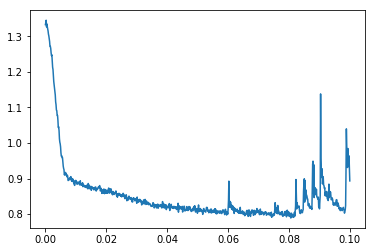

In [201]:
l1,l2 = lr_finder(1e-5,1e-1,model1,train_loader)

So learning rate of 0.005 seems fine

In [202]:
train_epocs1(model1, train_loader, valid_loader, lr=0.005, epochs=5, wd=1e-5)

Training Loss:1.8667210104456577
Validation Loss: 1.0107611717276312
Training Loss:1.8299641667089308
Validation Loss: 1.0066159812372122
Training Loss:1.8216431087455893
Validation Loss: 1.0010792696060826
Training Loss:1.8164390272844773
Validation Loss: 1.001074652766707
Training Loss:1.8125064076106545
Validation Loss: 0.999289570459679
